### 一.E步：确定隐变量，写出Q函数
利用朴素贝叶斯进行聚类，显然可以使用我们之前介绍过的EM算法咯...,我们可以假设观测数据$X_i(i=1,2,...,M)$是这样产生的，首先按照概率$\alpha_k(k=1,2,...,K)$选择第$k$个朴素贝叶斯模型，然后依第$k$个模型的概率分布生成观测数据$X_i$，这个选择的过程可以用隐变量$Z$来表示：   

$$
Z_{i,k}=\left\{\begin{matrix}
1 & 第i个观测来自第k个NB模型\\ 
0 & 否则
\end{matrix}\right.,i=1,2,...,M,k=1,2,...,K
$$  

按照$Q$函数所需，我们将它的另外两项写出来：   
第一项：全数据的似然函数   

$$
P(X_i,Z_{i,k}=1\mid \theta)=\alpha_k\prod_{j=1}^Np_k(X_i^j)
$$  

这里，$N$表示特征维度,$X_i^j$表示第$i$个观测数据的第$j$维特征取值，$p_k(X_i^j)$表示第$k$个朴素贝叶斯模型的条件概率，$\theta=\{\alpha_k,p_k(X_i^j)\}$  

第二项：隐变量的概率分布   

$$
P(Z_{i,k}=1\mid X_i,\theta^t)=\frac{\alpha_k^t\prod_{j=1}^Np_k(X_i^j)^t}{\sum_{l=1}^K\alpha_l^t\prod_{j=1}^Np_l(X_i^j)^t}=w_{i,k}^t
$$    

ps：注意有这样一个性质$\sum_{k=1}^Kw_{i,k}^t=1$

所以，我们的$Q$函数就可以写出来勒：   

$$
Q(\theta \mid \theta^t)=\sum_{Z_{i,k}}logP(X_i,Z_{i,k}=1\mid \theta)\cdot P(Z_{i,k}=1\mid X_i,\theta^t)\\
=\sum_{i=1}^M\sum_{k=1}^Kw_{i,k}^t[log\alpha_k+\sum_{j=1}^Nlogp_k(X_i^j)]\\
=\sum_{i=1}^M\sum_{k=1}^Kw_{i,k}^tlog\alpha_k+\sum_{k=1}^K\sum_{i=1}^Mw_{i,k}^t\sum_{j=1}^N\sum_{l=1}^{S(j)}logp_k(X_i^j)^{I(X_i^j=f_{j,l})}\\
s.t. \sum_{k=1}^K\alpha_k=1\\
\sum_{l=1}^{S(j)} p_k(X_i^j=f_{j,l})=1
$$

这里，$f_{j,1},f_{j,2},...,f_{j,S(j)}$表示$X_i^j,i=1,2,...,M$中不同取值的集合

### 二.M步：极大化Q函数
$\alpha_k$与$p_k(X_i^j)$相互没有关联，我们可以将$Q$函数拆解为两个目标函数的极大化过程，由于均含有约束条件，所以需要转换为拉格朗日函数，通过求KKT条件的方式来求解；   

#### 求$\alpha_k^{t+1}$

我们可以为$\alpha_k$构建一个拉格朗日函数：   

$$
L(\alpha,\beta)=-\sum_{i=1}^M\sum_{k=1}^Kw_{i,k}^tlog\alpha_k+\beta(1-\sum_{k=1}^K\alpha_k),\alpha=\{\alpha_1,\alpha_2,...,\alpha_K\}
$$  

原问题等价于求解：   

$$
\alpha^*=\arg\min_{\alpha}\max_{\beta}L(\alpha,\beta)
$$  

直接求下KKT条件：   

$$
\left\{\begin{matrix}
\frac{\partial L(\alpha,\beta)}{\partial \alpha_k}=\frac{-\sum_{i=1}^Mw_{i,k}^t}{\alpha_k}-\beta=0 & k=1,2,...,K\\ 
1-\sum_{k=1}^K\alpha_k=0 & 
\end{matrix}\right.
\Rightarrow\alpha_k^{t+1}=\frac{\sum_{i=1}^Mw_{i,k}^t}{M}
$$


#### 求$p_k(X_i^j)^{t+1}$

同样的，我们可以为$p_k(X_i^j)$构建一个拉格朗日函数   

$$
L(p,\beta)=-\sum_{k=1}^K\sum_{i=1}^Mw_{i,k}^t\sum_{j=1}^N\sum_{l=1}^{S(j)}logp_k(X_i^j)^{I(X_i^j=f_{j,l})}+\sum_{k=1}^K\sum_{j=1}^N\beta_{k,j}(1-\sum_{l=1}^{S(j)} p_k(X_i^j=f_{j,l}))
$$

原问题等价于：   

$$
p^*=arg\min_p\max_\beta L(p,\beta)
$$   

同样，对其求KKT条件：   

$$
\left\{\begin{matrix}
\frac{\partial L(p,\beta)}{\partial p_k(X_i^j=f_{j,l})} =-\frac{\sum_{i=1}^Mw_{i,k}^t}{p_k(X_i^j=f_{j,l})}-\beta_{k,j}=0&k=1,2,...,K,j=1,2,...,N \\ 
1-\sum_{l=1}^{S(j)}p_k(X_i^j=f_{j,l}) & k=1,2,...,K,j=1,2,...,N
\end{matrix}\right.\\
\Rightarrow p_k(X_i^j=f_{j,l})^{t+1}=\frac{\sum_{i=1}^Mw_{i,k}^tI(X_i^j=f_{i,l})}{\sum_{i=1}^Mw_{i,k}^t}
$$


### 三.代码实现

In [1]:
import os
os.chdir('../')
import numpy as np
from ml_models import utils
from ml_models.wrapper_models import DataBinWrapper
%matplotlib inline

"""
使用EM算法进行NB聚类，封装到ml_models.pgm
"""


class NaiveBayesCluster(object):
    def __init__(self, n_components=1, tol=1e-5, n_iter=100, max_bins=10, verbose=False):
        """
        :param n_components: 朴素贝叶斯模型数量
        :param tol: log likehold增益<tol时，停止训练
        :param n_iter: 最多迭代次数
        :param verbose: 是否可视化训练过程
        """
        self.n_components = n_components
        self.tol = tol
        self.n_iter = n_iter
        self.verbose = verbose
        # 分箱
        self.dbw = DataBinWrapper(max_bins=max_bins)
        # 参数
        self.p_y = {}
        self.p_x_y = {}
        # 默认参数
        self.default_y_prob = None  # y的默认概率
        self.default_x_prob = {}  # x的默认概率

    def get_log_w(self, x_bins):
        """
        获取隐变量
        :param x_bins:
        :return:
        """
        W = []
        for x_row in x_bins:
            tmp = []
            for k in range(0, self.n_components):
                llh = self.p_y[k]
                for j, x_ij in enumerate(x_row):
                    llh += self.p_x_y[k][j][x_ij]
                tmp.append(llh)
            W.append(tmp)
        W = np.asarray(W)
        return W

    def fit(self, x):
        n_sample = x.shape[0]
        self.dbw.fit(x)
        x_bins = self.dbw.transform(x)
        # 初始化模型参数
        self.default_y_prob = np.log(0.5 / self.n_components)  # 默认p_y
        for y_label in range(0, self.n_components):
            self.p_x_y[y_label] = {}
            self.p_y[y_label] = np.log(1.0 / self.n_components)  # 初始p_y设置一样
            self.default_x_prob[y_label] = np.log(0.5 / n_sample)  # 默认p_x_y
            # 初始p_x_y设置一样
            for j in range(0, x_bins.shape[1]):
                self.p_x_y[y_label][j] = {}
                x_j_set = set(x_bins[:, j])
                for x_j in x_j_set:
                    # 随机抽样计算条件概率
                    sample_x_index = np.random.choice(n_sample, n_sample // self.n_components)
                    sample_x_bins = x_bins[sample_x_index]
                    p_x_y = (np.sum(sample_x_bins[:, j] == x_j) + 1) / (
                        sample_x_bins.shape[0] + len(x_j_set))
                    self.p_x_y[y_label][j][x_j] = np.log(p_x_y)
        # 计算隐变量
        W_log = self.get_log_w(x_bins)
        W = utils.softmax(W_log)
        W_gen = np.exp(W_log)
        current_log_loss = np.log(W_gen.sum(axis=1)).sum()
        # 迭代训练
        current_epoch = 0
        for _ in range(0, self.n_iter):
            if self.verbose is True:
                utils.plot_decision_function(x, self.predict(x), self)
                utils.plt.pause(0.1)
                utils.plt.clf()
            # 更新模型参数
            for k in range(0, self.n_components):
                self.p_y[k] = np.log(np.sum(W[:, k]) / n_sample)
                for j in range(0, x_bins.shape[1]):
                    x_j_set = set(x_bins[:, j])
                    for x_j in x_j_set:
                        self.p_x_y[k][j][x_j] = np.log(
                            1e-10 + np.sum(W[:, k] * (x_bins[:, j] == x_j)) / np.sum(W[:, k]))

            # 更新隐变量
            W_log = self.get_log_w(x_bins)
            W = utils.softmax(W_log)
            W_gen = np.exp(W_log)
            # 计算log like hold
            new_log_loss = np.log(W_gen.sum(axis=1)).sum()
            if new_log_loss - current_log_loss > self.tol:
                current_log_loss = new_log_loss
                current_epoch += 1
            else:
                print('total epochs:', current_epoch)
                break
        if self.verbose:
            utils.plot_decision_function(x, self.predict(x), self)
            utils.plt.show()

    def predict_proba(self, x):
        x_bins = self.dbw.transform(x)
        rst = []
        for x_row in x_bins:
            tmp = []
            for y_index in range(0, self.n_components):
                try:
                    p_y_log = self.p_y[y_index]
                except:
                    p_y_log = self.default_y_prob
                for i, xij in enumerate(x_row):
                    try:
                        p_y_log += self.p_x_y[y_index][i][xij]
                    except:
                        p_y_log += self.default_x_prob[y_index]
                tmp.append(p_y_log)
            rst.append(tmp)
        return utils.softmax(np.asarray(rst))

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [2]:
#造伪数据
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

total epochs: 319


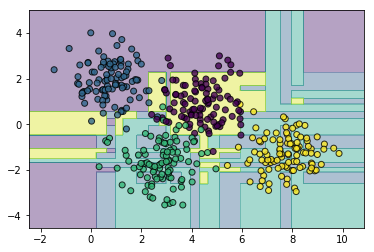

In [3]:
#查看效果
nbc = NaiveBayesCluster(n_iter=500, tol=1e-5, n_components=4, max_bins=20, verbose=False)
nbc.fit(X)
utils.plot_decision_function(X, y, nbc)

可以发现最上面的两种类别基本可以正确圈出来出来，最下面两种类别混为一种了，个人觉得下面两种数据点在横向上概率密度差不多，导致胶着，具体原因还有待探索

### 四.gaussian实现
按照前面的套路，我们可以假设$p_k(X_i^j)$来源于某一一维高斯分布$N(x\mid u_{k,j},\sigma_{k,j})$，即：   

$$
p_k(X_i^j)=\frac{1}{\sqrt{2\pi}\sigma_{k,j}}exp(-\frac{(X_i^j-u_{k,j})^2}{2\sigma_{k,j}^2})
$$  

同样的，可以通过极大似然估计得到均值和标准差的更新公式：   

$$
u_k^{t+1}=\frac{\sum_{i=1}^Mw_{i,k}^tx_i}{\sum_{i=1}^Mw_{i,k}^t}\\
$$

$$
\sigma_{k,j}^{t+1}=\sqrt{\frac{\sum_{i=1}^Mw_{i,k}^t(x_i-u_{k,j}^t)^2}{\sum_{i=1}^Mw_{i,k}^t}}
$$

In [4]:
"""
使用EM算法进行GaussianNB聚类，封装到ml_models.pgm
"""

class GaussianNBCluster(object):
    def __init__(self, n_components=1, tol=1e-5, n_iter=100, verbose=False):
        """
        :param n_components: 朴素贝叶斯模型数量
        :param tol: log likehold增益<tol时，停止训练
        :param n_iter: 最多迭代次数
        :param verbose: 是否可视化训练过程
        """
        self.n_components = n_components
        self.tol = tol
        self.n_iter = n_iter
        self.verbose = verbose

        # 参数
        self.p_y = {}
        self.p_x_y = {}
        # 默认参数
        self.default_y_prob = None  # y的默认概率

    def get_w(self, x):
        """
        获取隐变量
        :return:
        """
        W = []
        for k in range(0, self.n_components):
            tmp = []
            for j in range(0, x.shape[1]):
                tmp.append(np.log(utils.gaussian_1d(x[:, j], self.p_x_y[k][j][0], self.p_x_y[k][j][1])))
            W.append(np.sum(tmp, axis=0) + np.log(self.p_y[k]))
        W = np.asarray(W)
        return np.exp(W.T)

    def fit(self, x):
        n_sample = x.shape[0]

        # 初始化模型参数
        self.default_y_prob = np.log(0.5 / self.n_components)  # 默认p_y
        for y_label in range(0, self.n_components):
            self.p_x_y[y_label] = {}
            self.p_y[y_label] = 1.0 / self.n_components  # 初始p_y设置一样
            # 初始p_x_y设置一样
            for j in range(0, x.shape[1]):
                self.p_x_y[y_label][j] = {}
                u = np.mean(x[:, j], axis=0) + np.random.random() * (x[:, j].max() + x[:, j].min()) / 2
                sigma = np.std(x[:, j])
                self.p_x_y[y_label][j] = [u, sigma]

        # 计算隐变量
        W= self.get_w(x)
        current_log_loss = np.log(W.sum(axis=1)).sum()
        W = W / np.sum(W, axis=1, keepdims=True)
        # 迭代训练
        current_epoch = 0
        for _ in range(0, self.n_iter):
            if self.verbose is True:
                utils.plot_decision_function(x, self.predict(x), self)
                utils.plt.pause(0.1)
                utils.plt.clf()
            # 更新模型参数
            for k in range(0, self.n_components):
                self.p_y[k] = np.sum(W[:, k]) / n_sample
                for j in range(0, x.shape[1]):
                    x_j = x[:, j]
                    u = np.sum(x_j * W[:, k]) / np.sum(W[:, k])
                    sigma = np.sqrt(np.sum((x_j - u) * (x_j - u) * W[:, k]) / np.sum(W[:, k]))
                    self.p_x_y[k][j] = [u, sigma]

            # 更新隐变量
            W = self.get_w(x)
            new_log_loss = np.log(W.sum(axis=1)).sum()
            W = W / np.sum(W, axis=1, keepdims=True)
            if new_log_loss - current_log_loss > self.tol:
                current_log_loss = new_log_loss
                current_epoch += 1
            else:
                print('total epochs:', current_epoch)
                break
        if self.verbose:
            utils.plot_decision_function(x, self.predict(x), self)
            utils.plt.show()

    def predict_proba(self, x):
        rst = []
        for x_row in x:
            tmp = []
            for y_index in range(0, self.n_components):
                try:
                    p_y_log = self.p_y[y_index]
                except:
                    p_y_log = self.default_y_prob
                for i, xij in enumerate(x_row):
                    p_y_log += np.log(
                        1e-12 + utils.gaussian_1d(xij, self.p_x_y[y_index][i][0], self.p_x_y[y_index][i][1]))
                tmp.append(p_y_log)
            rst.append(tmp)
        return utils.softmax(np.asarray(rst))

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

total epochs: 59


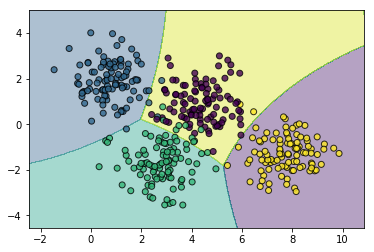

In [5]:
#查看效果
gnb = GaussianNBCluster(n_iter=200, tol=1e-5, n_components=4,verbose=False)
gnb.fit(X)
utils.plot_decision_function(X, y, gnb)